In [1]:
import sys
import timeit
import pickle
import codecs
import gensim
import operator
import itertools
import scipy as sp
import numpy as np
import pandas as pd
from konlpy.tag import Okt
from datetime import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
import matplotlib.dates as mdates
from matplotlib import font_manager

%matplotlib inline
#plt.rc('text', usetex = True) # use if latex is installed
plt.rcParams['text.latex.unicode'] = True
plt.rcParams["font.family"] = 'NanumMyeongjo'
plt.rcParams["font.size"] = 20

SMALL_SIZE = 14
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels

fm = mpl.font_manager

myeongjo = 'NanumMyeongjo'
gothic = 'NanumGothic'
number = 'DejaVu Sans'

#[(f.name, f.fname) for f in mpl.font_manager.fontManager.ttflist if 'Nanum' in f.name]

# 색 테마
# https://aesalazar.com/blog/3-professional-color-combinations-for-dashboards-or-mobile-bi-applications/

In [2]:
# 국산차게시판 데이터는 natCar
# 수입차게시판 데이터는 intCar
# 뉴스 데이터는 news
natCar = list()
intCar = list()
news = list()

with codecs.open('/home/youngwoo/Documents/Media_BigData/figure/korean.txt', 'r', encoding = 'UTF-8') as fs:
  
    data = eval(fs.read())
    
for d in data:
  
    temp = dict()
    temp['time'] = datetime.strptime(d['time'], '%Y.%m.%d')
    temp['title'] = d['title']
    temp['content'] = d['content']
    temp['reply'] = d['reply']
    natCar.append(temp)

with codecs.open('/home/youngwoo/Documents/Media_BigData/figure/international.txt', 'r', encoding = 'UTF-8') as fs:
  
    data = eval(fs.read())
    
for d in data:
  
    temp = dict()
    temp['time'] = datetime.strptime(d['time'], '%Y.%m.%d')
    temp['title'] = d['title']
    temp['content'] = d['content']
    temp['reply'] = d['reply']
    
    temp['content'] = temp['content'].replace('오토뷰', '')
    temp['content'] = temp['content'].replace('모터그래프', '')
    temp['content'] = temp['content'].replace('카미디어', '')
    temp['content'] = temp['content'].replace('기자', '')
    temp['content'] = temp['content'].replace('뉴스팀', '')
    
    intCar.append(temp)

with open('/home/youngwoo/Documents/Media_BigData/figure/news.pickle', 'rb') as fs:
  
    data = pickle.load(fs)

for d in data:
  
    if d['time'] >= datetime.strptime('2016-01-01', '%Y-%m-%d'):
        
        news.append(d)

In [6]:
len(news)

14647

In [170]:
df_nat = pd.DataFrame(natCar)
df_nat['len_reply'] = df_nat['reply'].map(len)
df_nat = df_nat[['title', 'content', 'time', 'reply', 'len_reply']]
df_int = pd.DataFrame(intCar)
df_int['len_reply'] = df_int['reply'].map(len)
df_int = df_int[['title', 'content', 'time', 'reply', 'len_reply']]
df_news = pd.DataFrame(news)
df_news = df_news[['title', 'content', 'time']]

#df_bmw = df_int.loc[df_int['content'].str.contains('BMW|bmw|화재|불|리콜|520d|520D')]
df_bmw = df_int.loc[(df_int['content'].str.contains('리콜') & df_int['content'].str.contains('비엠|BMW|bmw')) |
                   df_int['content'].str.contains('불|화재|520d|520D')]

#df_news_bmw = df_news.loc[df_news['content'].str.contains('화재|520d|520D')]
df_news_bmw = df_news.loc[(df_news['content'].str.contains('리콜') & df_news['content'].str.contains('비엠더블유|BMW|bmw')) |
                          df_news['content'].str.contains('화재|520d|520D')]
df_news_bmw = df_news_bmw.loc[~df_news_bmw['content'].str.contains('프로모션|이벤트|출시|모터쇼')]

df_nat_bmw = df_nat.loc[df_nat['content'].str.contains('화재|불|리콜|520d|520D')]

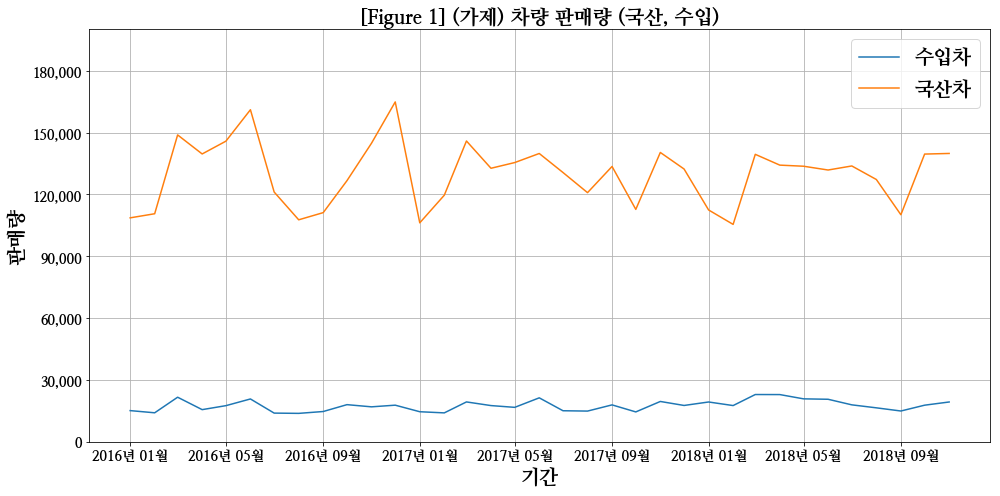

In [171]:
import_car_sales = pd.read_csv('/home/youngwoo/Documents/Media_BigData/figure/auto_import_sales_2016.csv', header=0, index_col=0)
import_car_sales = import_car_sales.transpose()
import_car_sales['imported_total'] = import_car_sales.sum(axis=1)

domestic_car_sales = pd.read_csv('/home/youngwoo/Documents/Media_BigData/figure/auto_domestic_sales.csv', header=0, index_col=0)
domestic_car_sales = domestic_car_sales.transpose()
domestic_car_sales['domestic_total'] = domestic_car_sales.sum(axis=1)

fig, ax = plt.subplots(1, 1, figsize = (14, 7))

ax.plot(pd.to_datetime(import_car_sales.T.keys(), format = '%Y%m'), import_car_sales.imported_total, label = '수입차')
ax.plot(pd.to_datetime(domestic_car_sales.T.keys(), format = '%Y%m'), domestic_car_sales.domestic_total, label = '국산차')

ax.set_title(r'[Figure 1] (가제) 차량 판매량 (국산, 수입)', fontsize = 20, fontname = myeongjo)
ax.set_xlabel('기간', fontsize = 20, fontname = myeongjo)
ax.set_ylabel('판매량', fontsize = 20, fontname = myeongjo)
ax.legend(loc = 'upper right', fontsize = 20)
ax.grid(True)

ax.get_xaxis().set_major_formatter(mdates.DateFormatter('%Y년 %m월'))
ax.get_yaxis().set_major_formatter(tkr.FuncFormatter(lambda x, p: format(int(x), ',')))

ax.set_ylim(0, 200000)
ax.set_yticks(np.arange(0, 180000 + 1, 30000))

fig.tight_layout()
plt.show()

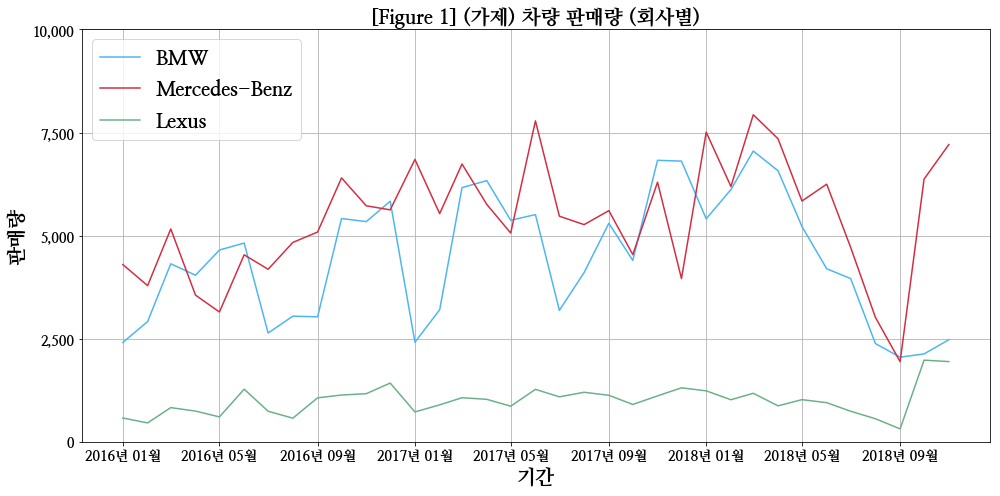

In [172]:
import_car_sales = pd.read_csv('/home/youngwoo/Documents/Media_BigData/figure/auto_import_sales_2016.csv', header=0, index_col=0)
import_car_sales = import_car_sales.transpose()
import_car_sales['imported_total'] = import_car_sales.sum(axis=1)

fig, ax = plt.subplots(1, 1, figsize = (14, 7))

ax.plot(pd.to_datetime(import_car_sales.T.keys(), format = '%Y%m'), import_car_sales['BMW'],
        label = 'BMW', color = '#4CB5F5')
ax.plot(pd.to_datetime(import_car_sales.T.keys(), format = '%Y%m'), import_car_sales['Mercedes-Benz'],
        label = 'Mercedes-Benz', color = '#D32D41')
ax.plot(pd.to_datetime(import_car_sales.T.keys(), format = '%Y%m'), import_car_sales['Lexus'],
        label = 'Lexus', color = '#6AB187')

ax.set_title(r'[Figure 1] (가제) 차량 판매량 (회사별)', fontsize = 20, fontname = myeongjo)
ax.set_xlabel('기간', fontsize = 20, fontname = myeongjo)
ax.set_ylabel('판매량', fontsize = 20, fontname = myeongjo)
ax.legend(loc = 'upper left', fontsize = 20)
ax.grid(True)

ax.get_xaxis().set_major_formatter(mdates.DateFormatter('%Y년 %m월'))
ax.get_yaxis().set_major_formatter(tkr.FuncFormatter(lambda x, p: format(int(x), ',')))

ax.set_ylim(0, 10000)
ax.set_yticks(np.arange(0, 10000 + 1, 2500))

fig.tight_layout()
plt.show()

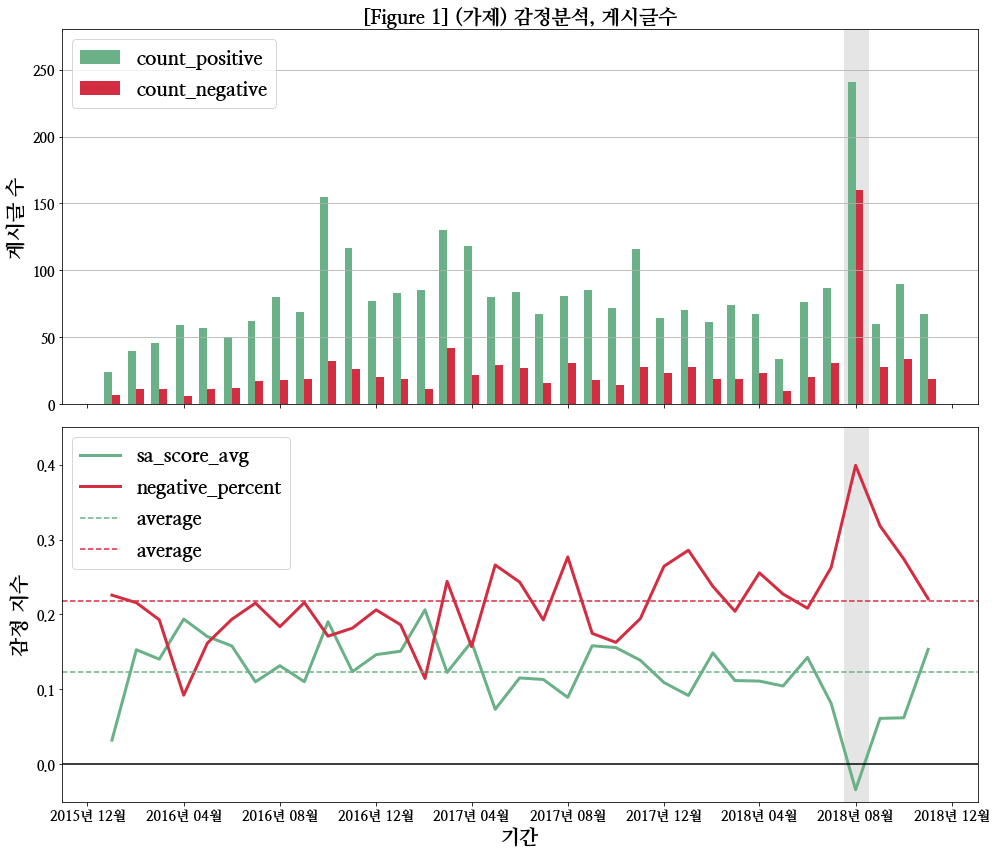

In [173]:
pd_series = pd.read_csv('/home/youngwoo/Documents/Media_BigData/figure/sa_result.csv', header=0, index_col=0)
pd_series = pd_series.transpose()
pd_series['negative_percent'] = pd_series['count_negative'] / pd_series['count']

fig, ax = plt.subplots(2, 1, figsize = (14, 12), sharex = True)

ax[0].axvline(x = mdates.date2num(pd.to_datetime(pd_series['count_positive'].T.keys()[-4], format = '%Y-%m')),
              color = 'gray', lw = 25, alpha = 0.2, zorder = 0)
ax[0].bar(mdates.date2num(pd.to_datetime(pd_series['count_positive'].T.keys(), format = '%Y-%m')) - 5,
        pd_series['count_positive'].T.values, label = 'count_positive', color = '#6AB187', width = 10, zorder = 1)
ax[0].bar(mdates.date2num(pd.to_datetime(pd_series['count_negative'].T.keys(), format = '%Y-%m')) + 5,
        pd_series['count_negative'].T.values, label = 'count_negative', color = '#D32D41', width = 10, zorder = 1)

ax[1].axvline(x = mdates.date2num(pd.to_datetime(pd_series['count_positive'].T.keys()[-4], format = '%Y-%m')),
              color = 'gray', lw = 25, alpha = 0.2, zorder = 0)
ax[1].plot(pd.to_datetime(pd_series['sa_score_avg'].T.keys(), format = '%Y-%m'),
         pd_series['sa_score_avg'].T.values, label = 'sa_score_avg', color = '#6AB187', lw = 3, zorder = 1)
ax[1].plot(pd.to_datetime(pd_series['negative_percent'].T.keys(), format = '%Y-%m'),
         pd_series['negative_percent'].T.values, label = 'negative_percent', color = '#D32D41', lw = 3, zorder = 1)

ax[1].set_xlim(ax[1].get_xlim())
ax[1].plot(ax[1].get_xlim(), [pd_series['sa_score_avg'].T.mean(), pd_series['sa_score_avg'].T.mean()],
         color = '#6AB187', linestyle = '--', label = 'average')
ax[1].plot(ax[1].get_xlim(), [pd_series['negative_percent'].T.mean(), pd_series['negative_percent'].T.mean()],
         c = '#D32D41', linestyle = '--', label = 'average')
ax[1].plot(ax[1].get_xlim(), [0, 0], c = 'k', linestyle = '-')

ax[0].set_title(r'[Figure 1] (가제) 감정분석, 게시글수', fontsize = 20, fontname = myeongjo)
ax[0].set_ylabel('게시글 수', fontsize = 20, fontname = myeongjo)
ax[0].legend(loc = 'upper left', fontsize = 20)

ax[1].set_xlabel('기간', fontsize = 20, fontname = myeongjo)
ax[1].set_ylabel('감정 지수', fontsize = 20, fontname = myeongjo)
ax[1].legend(loc = 'upper left', fontsize = 20)

ax[0].grid(axis = 'y')

ax[0].get_xaxis().set_major_formatter(mdates.DateFormatter('%Y년 %m월'))
ax[0].get_yaxis().set_major_formatter(tkr.FuncFormatter(lambda x, p: format(int(x), ',')))

ax[0].set_ylim(0, 280)
ax[0].set_yticks(np.arange(0, 250 + 1, 50))

ax[1].set_ylim(-0.05, 0.45)

fig.tight_layout()
plt.show()

In [186]:
x_nat_year = df_nat['title'].groupby([df_nat["time"].dt.year.rename('year'),
                                  df_nat["time"].dt.month.rename('month')]).count().T[1:].index.get_level_values(level = 0)
x_nat_month = df_nat['title'].groupby([df_nat["time"].dt.year.rename('year'),
                                   df_nat["time"].dt.month.rename('month')]).count().T[1:].index.get_level_values(level = 1)
x_nat_date = pd.DataFrame(x_nat_year, x_nat_month)
x_nat_date['date'] = pd.to_datetime(x_nat_date['year'].astype(int).astype(str) + '-' + x_nat_date.index.astype(int).astype(str))
y_nat = df_nat['title'].groupby([df_nat["time"].dt.year.rename('year'), df_nat["time"].dt.month.rename('month')]).count().T[1:].values

x_int_year = df_int['title'].groupby([df_int["time"].dt.year.rename('year'),
                                  df_int["time"].dt.month.rename('month')]).count().T[18:].index.get_level_values(level = 0)
x_int_month = df_nat['title'].groupby([df_int["time"].dt.year.rename('year'),
                                   df_int["time"].dt.month.rename('month')]).count().T[18:].index.get_level_values(level = 1)
x_int_date = pd.DataFrame(x_int_year, x_int_month)
x_int_date['date'] = pd.to_datetime(x_int_date['year'].astype(int).astype(str) + '-' + x_int_date.index.astype(int).astype(str))
y_int = df_int['title'].groupby([df_int["time"].dt.year.rename('year'), df_int["time"].dt.month.rename('month')]).count().T[18:].values

x_bmw_year = df_bmw['title'].groupby([df_bmw["time"].dt.year.rename('year'),
                                  df_bmw["time"].dt.month.rename('month')]).count().T[1:].index.get_level_values(level = 0)
x_bmw_month = df_bmw['title'].groupby([df_bmw["time"].dt.year.rename('year'),
                                   df_bmw["time"].dt.month.rename('month')]).count().T[1:].index.get_level_values(level = 1)
x_bmw_date = pd.DataFrame(x_bmw_year, x_bmw_month)
x_bmw_date['date'] = pd.to_datetime(x_bmw_date['year'].astype(int).astype(str) + '-' + x_bmw_date.index.astype(int).astype(str))
y_bmw = df_bmw['title'].groupby([df_bmw["time"].dt.year.rename('year'), df_bmw["time"].dt.month.rename('month')]).count().T[1:].values
y_bmw_ratio = y_bmw[17:] / y_int * 100

x_nat_bmw_year = df_nat_bmw['title'].groupby([df_nat_bmw["time"].dt.year.rename('year'),
                                              df_nat_bmw["time"].dt.month.rename('month')]).count().T[1:].index.get_level_values(level = 0)
x_nat_bmw_month = df_nat_bmw['title'].groupby([df_nat_bmw["time"].dt.year.rename('year'),
                                               df_nat_bmw["time"].dt.month.rename('month')]).count().T[1:].index.get_level_values(level = 1)
x_nat_bmw_date = pd.DataFrame(x_nat_bmw_year, x_nat_bmw_month)
x_nat_bmw_date['date'] = pd.to_datetime(x_nat_bmw_date['year'].astype(int).astype(str) + '-' +
                                        x_nat_bmw_date.index.astype(int).astype(str))
y_nat_bmw = df_nat_bmw['title'].groupby([df_nat_bmw["time"].dt.year.rename('year'),
                                         df_nat_bmw["time"].dt.month.rename('month')]).count().T[1:].values

x_news_bmw_year = df_news_bmw['title'].groupby([df_news_bmw["time"].dt.year.rename('year'),
                                  df_news_bmw["time"].dt.month.rename('month')]).count().T[1:].index.get_level_values(level = 0)
x_news_bmw_month = df_news_bmw['title'].groupby([df_news_bmw["time"].dt.year.rename('year'),
                                   df_news_bmw["time"].dt.month.rename('month')]).count().T[1:].index.get_level_values(level = 1)
x_news_bmw_date = pd.DataFrame(x_news_bmw_year, x_news_bmw_month)
x_news_bmw_date['date'] = pd.to_datetime(x_news_bmw_date['year'].astype(int).astype(str) + '-' +
                                         x_news_bmw_date.index.astype(int).astype(str))
y_news_bmw = df_news_bmw['title'].groupby([df_news_bmw["time"].dt.year.rename('year'),
                                           df_news_bmw["time"].dt.month.rename('month')]).count().T[1:].values

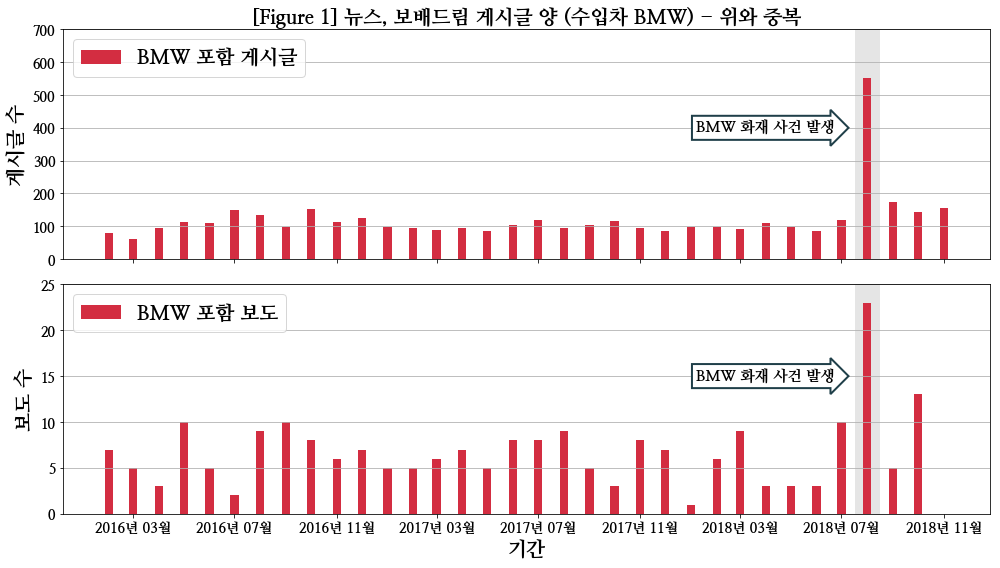

In [175]:
fig, ax = plt.subplots(2, 1, figsize = (14, 8), sharex = True)

ax[0].bar(x_bmw_date['date'].values, y_bmw, label = 'BMW 포함 게시글', width = 10, color = '#D32D41', zorder = 1)
ax[0].axvline(x = mdates.date2num(x_bmw_date['date'].values)[-4],
           color = 'gray', lw = 25, alpha = 0.2, zorder = 0)

ax[1].bar(x_news_bmw_date['date'].values, y_news_bmw, label = 'BMW 포함 보도', width = 10, color = '#D32D41', zorder = 1)
ax[1].axvline(x = mdates.date2num(x_news_bmw_date['date'].values)[-3],
           color = 'gray', lw = 25, alpha = 0.2, zorder = 0)

ax[0].set_title(r'[Figure 1] 뉴스, 보배드림 게시글 양 (수입차 BMW) - 위와 중복', fontsize = 20, fontname = myeongjo)
ax[0].set_ylabel('게시글 수', fontsize = 20, fontname = myeongjo)
ax[0].legend(loc = 'upper left', fontsize = 20)
ax[0].grid(axis = 'y')

ax[1].set_ylabel('보도 수', fontsize = 20, fontname = myeongjo)
ax[1].legend(loc = 'upper left', fontsize = 20)
ax[1].grid(axis = 'y')

ax[0].get_xaxis().set_major_formatter(mdates.DateFormatter('%Y년 %m월'))
ax[0].get_yaxis().set_major_formatter(tkr.FuncFormatter(lambda x, p: format(int(x), ',')))
ax[1].get_xaxis().set_major_formatter(mdates.DateFormatter('%Y년 %m월'))
ax[1].get_yaxis().set_major_formatter(tkr.FuncFormatter(lambda x, p: format(int(x), ',')))

ax[1].set_xlabel('기간', fontsize = 20, fontname = myeongjo)

ax[0].set_ylim(0, 700)
ax[0].set_yticks(np.arange(0, 700 + 1, 100))
ax[1].set_ylim(0, 25)
ax[1].set_yticks(np.arange(0, 25 + 1, 5))

ax[0].text(mdates.date2num(x_bmw_date['date'].values[-8]), 400,
           'BMW 화재 사건 발생', ha = 'center', va = 'center', rotation = 0, size = 15,
           bbox = dict(boxstyle = 'rarrow', fc = (1, 1, 1), ec = '#1F3F49', lw = 2))

ax[1].text(mdates.date2num(x_news_bmw_date['date'].values[-7]), 15,
           'BMW 화재 사건 발생', ha = 'center', va = 'center', rotation = 0, size = 15,
           bbox = dict(boxstyle = 'rarrow', fc = (1, 1, 1), ec = '#1F3F49', lw = 2))

fig.tight_layout()
plt.show()

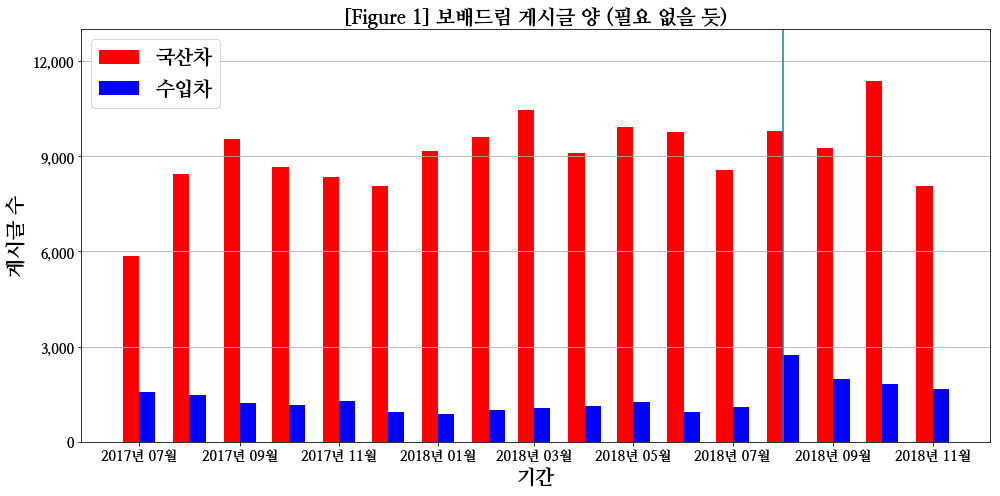

In [176]:
fig, ax = plt.subplots(1, 1, figsize = (14, 7))

ax.plot(x_nat_date['date'].values, y_nat, lw = 0, color = 'r')
ax.bar(mdates.date2num(x_nat_date['date'].values) - 5, y_nat, label = '국산차', width = 10, lw = 3, color = 'r')
ax.bar(mdates.date2num(x_int_date['date'].values) + 5, y_int, label = '수입차', width = 10, lw = 3, color = 'b')
ax.axvline(x = mdates.date2num(x_nat_date['date'].values)[-4])

ax.set_title(r'[Figure 1] 보배드림 게시글 양 (필요 없을 듯)', fontsize = 20, fontname = myeongjo)
ax.set_xlabel('기간', fontsize = 20, fontname = myeongjo)
ax.set_ylabel('게시글 수', fontsize = 20, fontname = myeongjo)
ax.legend(loc = 'upper left', fontsize = 20)
ax.grid(axis = 'y')

ax.get_xaxis().set_major_formatter(mdates.DateFormatter('%Y년 %m월'))
ax.get_yaxis().set_major_formatter(tkr.FuncFormatter(lambda x, p: format(int(x), ',')))

ax.set_ylim(0, 13000)
ax.set_yticks(np.arange(0, 13000 + 1, 3000))

fig.tight_layout()
plt.show()

In [187]:
print(len(y_int))
print(len(x_int_date['date']))

17
17


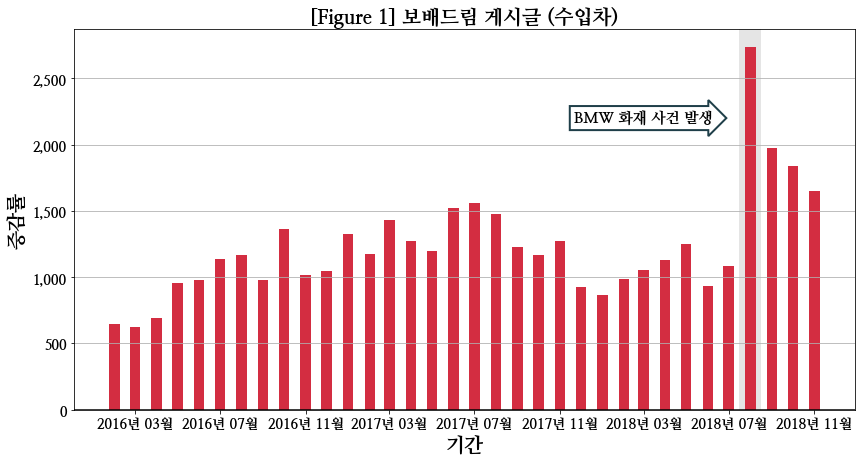

In [204]:
y_int = df_int['title'].groupby([df_int["time"].dt.year.rename('year'), df_int["time"].dt.month.rename('month')]).count().T.values

fig, ax = plt.subplots(1, 1, figsize = (14, 7))

ax.bar(x_bmw_date['date'].values, y_int[1:], label = '수입차',
       width = 15, color = '#D32D41', zorder = 1)
#ax.bar(x_bmw_date['date'].values, (y_int[1:] - y_int[:-1]) / y_int[1:] * 100, label = '수입차',
#       width = 15, color = '#D32D41', zorder = 1)
ax.axvline(x = mdates.date2num(x_int_date['date'].values)[-4],
          color = 'gray', lw = 22, alpha = 0.2, zorder = 0)
ax.axhline(y = 0, color = 'k')

ax.set_title(r'[Figure 1] 보배드림 게시글 (수입차)', fontsize = 20, fontname = myeongjo)
ax.set_xlabel('기간', fontsize = 20, fontname = myeongjo)
ax.set_ylabel('증감률', fontsize = 20, fontname = myeongjo)

ax.text(mdates.date2num(x_int_date['date'].values[-9]), 2200,
        'BMW 화재 사건 발생', ha = 'center', va = 'center', rotation = 0, size = 15,
        bbox = dict(boxstyle = 'rarrow', fc = (1, 1, 1), ec = '#1F3F49', lw = 2))

ax.get_xaxis().set_major_formatter(mdates.DateFormatter('%Y년 %m월'))
ax.get_yaxis().set_major_formatter(tkr.FuncFormatter(lambda x, p: format(int(x), ',')))

ax.grid(axis = 'y')

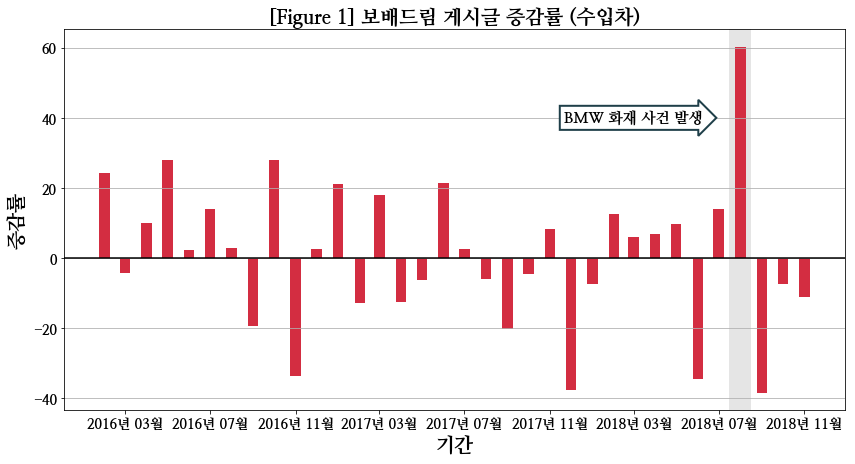

In [205]:
y_int = df_int['title'].groupby([df_int["time"].dt.year.rename('year'), df_int["time"].dt.month.rename('month')]).count().T.values

fig, ax = plt.subplots(1, 1, figsize = (14, 7))

ax.bar(x_bmw_date['date'].values, (y_int[1:] - y_int[:-1]) / y_int[1:] * 100, label = '수입차',
       width = 15, color = '#D32D41', zorder = 1)
ax.axvline(x = mdates.date2num(x_int_date['date'].values)[-4],
          color = 'gray', lw = 22, alpha = 0.2, zorder = 0)
ax.axhline(y = 0, color = 'k')

ax.set_title(r'[Figure 1] 보배드림 게시글 증감률 (수입차)', fontsize = 20, fontname = myeongjo)
ax.set_xlabel('기간', fontsize = 20, fontname = myeongjo)
ax.set_ylabel('증감률', fontsize = 20, fontname = myeongjo)

ax.text(mdates.date2num(x_int_date['date'].values[-9]), 40,
        'BMW 화재 사건 발생', ha = 'center', va = 'center', rotation = 0, size = 15,
        bbox = dict(boxstyle = 'rarrow', fc = (1, 1, 1), ec = '#1F3F49', lw = 2))

ax.get_xaxis().set_major_formatter(mdates.DateFormatter('%Y년 %m월'))
ax.get_yaxis().set_major_formatter(tkr.FuncFormatter(lambda x, p: format(int(x), ',')))

ax.grid(axis = 'y')

In [214]:
okt = Okt()

# 국산차게시판 데이터는 natCar
# 수입차게시판 데이터는 intCar
# 뉴스 데이터는 news

# 2018년 8, 9, 월
# 2018년 6, 7 월 로 나눔

before_natCar = list()
before_intCar = list()
before_news = list()
after_natCar = list()
after_intCar = list()
after_news = list()

for d in natCar:
    
    if datetime.strptime('2018-08-01', '%Y-%m-%d') <= d['time'] and d['time'] < datetime.strptime('2018-10-01', '%Y-%m-%d'):
        
        after_natCar.append(d)
        
    elif datetime.strptime('2018-06-01', '%Y-%m-%d') <= d['time'] and d['time'] < datetime.strptime('2018-08-01', '%Y-%m-%d'):
        
        before_natCar.append(d)
        
    else:
        
        pass
    
for d in intCar:
    
    if datetime.strptime('2018-08-01', '%Y-%m-%d') <= d['time'] and d['time'] < datetime.strptime('2018-10-01', '%Y-%m-%d'):
        
        after_intCar.append(d)
        
    elif datetime.strptime('2018-06-01', '%Y-%m-%d') <= d['time'] and d['time'] < datetime.strptime('2018-08-01', '%Y-%m-%d'):
        
        before_intCar.append(d)
        
    else:
        
        pass
    
for d in news:
    
    if datetime.strptime('2018-08-01', '%Y-%m-%d') <= d['time'] and d['time'] < datetime.strptime('2018-10-01', '%Y-%m-%d'):
        
        after_news.append(d)
        
    elif datetime.strptime('2018-06-01', '%Y-%m-%d') <= d['time'] and d['time'] < datetime.strptime('2018-08-01', '%Y-%m-%d'):
        
        before_news.append(d)
        
    else:
        
        pass

    
before_news_BMW = list()
after_news_BMW = list()

for d in news:
    
    if any(sb in d['content'] for sb in ['BMW', 'bmw', '비엠더블유']):
    
        if datetime.strptime('2018-08-01', '%Y-%m-%d') <= d['time'] and d['time'] < datetime.strptime('2018-10-01', '%Y-%m-%d'):

            after_news_BMW.append(d)

        elif datetime.strptime('2018-06-01', '%Y-%m-%d') <= d['time'] and d['time'] < datetime.strptime('2018-08-01', '%Y-%m-%d'):

            before_news_BMW.append(d)

        else:

            pass
    
def POS(string):
    
    result = list()
    
    temp = okt.pos(string, norm = True, stem = True)
    
    for t in temp:
        
        # 동사를 넣느냐 넣지 않느냐
        #if t[1] == 'Verb' or t[1] == 'Noun' or t[1] == 'Foreign' or t[1] == 'Adjective':
        #if (t[1] == 'Noun' or t[1] == 'Alpha' or t[1] == 'Adjective') and len(t[0]) > 1:
        if (t[1] == 'Noun' or t[1] == 'Alpha') and len(t[0]) > 1:
            
            result.append(t[0])
            
    return result

def top30word(data, n):
    
    doc = [d['title'].lower() + ' ' + d['content'].lower() for d in data]
    doc_POS = list(map(POS, doc))
    
    word_dict = set(list(itertools.chain.from_iterable(doc_POS)))
    word_dict = set([w for w in word_dict if len(w) > 1])
    
    word_count = {w:sum([d.count(w) for d in doc_POS]) for w in word_dict}
    word_count = sorted(word_count.items(), key = lambda kv : kv[1], reverse = True)

    for d in word_count[:n]:

        print(d)
        
    return doc_POS, word_dict, word_count

print('# of data (before_natCar) : ', len(before_natCar))
print('# of data (before_intCar) : ', len(before_intCar))
print('# of data (before_news)   : ', len(before_news))
print('# of data (after_natCar)  : ', len(after_natCar))
print('# of data (after_intCar)  : ', len(after_intCar))
print('# of data (after_news)    : ', len(after_news))

# of data (before_natCar) :  18336
# of data (before_intCar) :  2015
# of data (before_news)   :  792
# of data (after_natCar)  :  19052
# of data (after_intCar)  :  4708
# of data (after_news)    :  544


In [221]:
okt = Okt()

# 국산차게시판 데이터는 natCar
# 수입차게시판 데이터는 intCar
# 뉴스 데이터는 news

# 2018년 8, 9, 월
# 2018년 6, 7 월 로 나눔

before_natCar = list()
before_intCar = list()
before_news = list()
after_natCar = list()
after_intCar = list()
after_news = list()

for d in natCar:
    
    if datetime.strptime('2018-07-15', '%Y-%m-%d') <= d['time'] and d['time'] < datetime.strptime('2018-09-15', '%Y-%m-%d'):
        
        after_natCar.append(d)
        
    elif datetime.strptime('2018-05-15', '%Y-%m-%d') <= d['time'] and d['time'] < datetime.strptime('2018-07-15', '%Y-%m-%d'):
        
        before_natCar.append(d)
        
    else:
        
        pass
    
for d in intCar:
    
    if datetime.strptime('2018-07-15', '%Y-%m-%d') <= d['time'] and d['time'] < datetime.strptime('2018-09-15', '%Y-%m-%d'):
        
        after_intCar.append(d)
        
    elif datetime.strptime('2018-05-15', '%Y-%m-%d') <= d['time'] and d['time'] < datetime.strptime('2018-07-15', '%Y-%m-%d'):
        
        before_intCar.append(d)
        
    else:
        
        pass
    
for d in news:
    
    if datetime.strptime('2018-07-15', '%Y-%m-%d') <= d['time'] and d['time'] < datetime.strptime('2018-09-15', '%Y-%m-%d'):
        
        after_news.append(d)
        
    elif datetime.strptime('2018-05-15', '%Y-%m-%d') <= d['time'] and d['time'] < datetime.strptime('2018-07-15', '%Y-%m-%d'):
        
        before_news.append(d)
        
    else:
        
        pass

    
before_news_BMW = list()
after_news_BMW = list()

for d in news:
    
    if any(sb in d['content'] for sb in ['BMW', 'bmw', '비엠더블유']):
    
        if datetime.strptime('2018-07-15', '%Y-%m-%d') <= d['time'] and d['time'] < datetime.strptime('2018-09-15', '%Y-%m-%d'):

            after_news_BMW.append(d)

        elif datetime.strptime('2018-05-15', '%Y-%m-%d') <= d['time'] and d['time'] < datetime.strptime('2018-07-15', '%Y-%m-%d'):

            before_news_BMW.append(d)

        else:

            pass
    
def POS(string):
    
    result = list()
    
    temp = okt.pos(string, norm = True, stem = True)
    
    for t in temp:
        
        # 동사를 넣느냐 넣지 않느냐
        #if t[1] == 'Verb' or t[1] == 'Noun' or t[1] == 'Foreign' or t[1] == 'Adjective':
        #if (t[1] == 'Noun' or t[1] == 'Alpha' or t[1] == 'Adjective') and len(t[0]) > 1:
        if (t[1] == 'Noun' or t[1] == 'Alpha') and len(t[0]) > 1:
            
            result.append(t[0])
            
    return result

def top30word(data, n):
    
    doc = [d['title'].lower() + ' ' + d['content'].lower() for d in data]
    doc_POS = list(map(POS, doc))
    
    word_dict = set(list(itertools.chain.from_iterable(doc_POS)))
    word_dict = set([w for w in word_dict if len(w) > 1])
    
    word_count = {w:sum([d.count(w) for d in doc_POS]) for w in word_dict}
    word_count = sorted(word_count.items(), key = lambda kv : kv[1], reverse = True)

    for d in word_count[:n]:

        print(d)
        
    return doc_POS, word_dict, word_count

print('# of data (before_natCar) : ', len(before_natCar))
print('# of data (before_intCar) : ', len(before_intCar))
print('# of data (before_news)   : ', len(before_news))
print('# of data (after_natCar)  : ', len(after_natCar))
print('# of data (after_intCar)  : ', len(after_intCar))
print('# of data (after_news)    : ', len(after_news))

# of data (before_natCar) :  19146
# of data (before_intCar) :  2111
# of data (before_news)   :  748
# of data (after_natCar)  :  19243
# of data (after_intCar)  :  4481
# of data (after_news)    :  658


In [222]:
before_news_tagged = top30word(before_news_BMW, 30) # 동사 미포함

('bmw', 463)
('모델', 329)
('브랜드', 222)
('성능', 154)
('자동차', 152)
('엔진', 137)
('차량', 134)
('suv', 125)
('주행', 121)
('마력', 119)
('타이어', 119)
('모터쇼', 114)
('디자인', 114)
('시장', 111)
('시스템', 108)
('적용', 101)
('변속기', 100)
('공개', 98)
('벤츠', 98)
('통해', 94)
('예정', 94)
('기술', 93)
('출력', 91)
('최고', 89)
('판매', 88)
('그룹', 88)
('국내', 86)
('세대', 82)
('km', 82)
('아우디', 80)


In [223]:
after_news_tagged = top30word(after_news_BMW, 30) # 동사 미포함

('bmw', 486)
('모델', 345)
('차량', 173)
('엔진', 142)
('브랜드', 139)
('자동차', 134)
('리콜', 122)
('소비자', 113)
('적용', 109)
('화재', 107)
('서비스', 102)
('예정', 102)
('안전', 101)
('진단', 96)
('디자인', 94)
('코리아', 93)
('벤츠', 87)
('디젤', 86)
('위해', 85)
('시장', 84)
('판매', 84)
('통해', 83)
('센터', 83)
('공장', 81)
('성능', 81)
('가격', 76)
('클래스', 73)
('메르세데스', 70)
('때문', 69)
('시스템', 69)


In [224]:
before_intCar_tagged = top30word(before_intCar, 30) # 동사 미포함

('차량', 438)
('벤츠', 328)
('정도', 309)
('생각', 307)
('bmw', 304)
('가격', 220)
('모델', 208)
('센터', 207)
('고민', 203)
('구매', 179)
('수입', 176)
('디젤', 168)
('형님', 165)
('수리', 162)
('지금', 160)
('그냥', 155)
('vs', 150)
('추천', 143)
('주행', 143)
('아우디', 141)
('딜러', 140)
('질문', 139)
('이번', 135)
('엔진', 130)
('문제', 130)
('중고', 129)
('신형', 128)
('할인', 127)
('견적', 126)
('사람', 122)


In [225]:
after_intCar_tagged = top30word(after_intCar, 30) # 동사 미포함

('bmw', 1182)
('차량', 853)
('벤츠', 798)
('아우디', 578)
('생각', 570)
('화재', 552)
('정도', 509)
('사람', 452)
('비엠', 397)
('문제', 370)
('엔진', 364)
('amp', 348)
('가격', 340)
('디젤', 335)
('지금', 329)
('그냥', 317)
('수입', 308)
('리콜', 306)
('센터', 289)
('모델', 283)
('자동차', 269)
('이번', 257)
('오늘', 251)
('구매', 248)
('브랜드', 244)
('형님', 236)
('때문', 235)
('서비스', 233)
('진짜', 232)
('추천', 228)


In [226]:
common_dictionary = gensim.corpora.dictionary.Dictionary(before_news_tagged[0])
common_corpus = [common_dictionary.doc2bow(text) for text in before_news_tagged[0]]

lda = gensim.models.ldamodel.LdaModel(common_corpus, num_topics = 4, id2word = common_dictionary, passes = 10)
topics = lda.print_topics(num_words = 8)
for topic in topics:
    print(topic)

(0, '0.016*"브랜드" + 0.011*"bmw" + 0.010*"아우디" + 0.009*"suv" + 0.009*"폭스바겐" + 0.009*"자동차" + 0.008*"벤츠" + 0.007*"그룹"')
(1, '0.024*"bmw" + 0.013*"모델" + 0.009*"모터쇼" + 0.007*"마력" + 0.007*"시스템" + 0.007*"차량" + 0.007*"엔진" + 0.007*"디자인"')
(2, '0.019*"모델" + 0.012*"bmw" + 0.011*"변속기" + 0.009*"자동차" + 0.009*"클러치" + 0.009*"브랜드" + 0.008*"성능" + 0.007*"시장"')
(3, '0.024*"타이어" + 0.014*"bmw" + 0.011*"모델" + 0.011*"성능" + 0.010*"브랜드" + 0.009*"suv" + 0.008*"볼보" + 0.007*"주행"')


In [227]:
common_dictionary = gensim.corpora.dictionary.Dictionary(after_news_tagged[0])
common_corpus = [common_dictionary.doc2bow(text) for text in after_news_tagged[0]]

lda = gensim.models.ldamodel.LdaModel(common_corpus, num_topics = 4, id2word = common_dictionary, passes = 10)
topics = lda.print_topics(num_words = 8)
for topic in topics:
    print(topic)

(0, '0.024*"모델" + 0.020*"bmw" + 0.012*"디자인" + 0.008*"적용" + 0.008*"suv" + 0.007*"신형" + 0.007*"엔진" + 0.007*"고성능"')
(1, '0.014*"bmw" + 0.011*"공장" + 0.008*"모델" + 0.007*"선택" + 0.006*"line" + 0.006*"렉서스" + 0.006*"차체" + 0.006*"rc"')
(2, '0.019*"모델" + 0.012*"브랜드" + 0.010*"bmw" + 0.010*"소비자" + 0.009*"엔진" + 0.007*"자동차" + 0.007*"벤츠" + 0.007*"디젤"')
(3, '0.036*"bmw" + 0.019*"리콜" + 0.018*"차량" + 0.016*"화재" + 0.015*"진단" + 0.015*"안전" + 0.014*"서비스" + 0.012*"코리아"')


In [228]:
common_dictionary = gensim.corpora.dictionary.Dictionary(before_intCar_tagged[0])
common_corpus = [common_dictionary.doc2bow(text) for text in before_intCar_tagged[0]]

lda = gensim.models.ldamodel.LdaModel(common_corpus, num_topics = 4, id2word = common_dictionary, passes = 10)
topics = lda.print_topics(num_words = 8)
for topic in topics:
    print(topic)

(0, '0.019*"구안" + 0.014*"적용" + 0.012*"뉴티" + 0.012*"모델" + 0.011*"차량" + 0.008*"센터" + 0.007*"느낌" + 0.007*"서비스"')
(1, '0.014*"차량" + 0.013*"디젤" + 0.012*"정도" + 0.011*"벤츠" + 0.011*"스팅어" + 0.009*"출시" + 0.008*"클래스" + 0.008*"생각"')
(2, '0.013*"고민" + 0.011*"gt" + 0.010*"bmw" + 0.009*"구매" + 0.009*"지금" + 0.009*"벤츠" + 0.008*"수입" + 0.008*"생각"')
(3, '0.015*"견적" + 0.010*"딜러" + 0.010*"차량" + 0.007*"정도" + 0.007*"벤츠" + 0.006*"그냥" + 0.006*"사람" + 0.006*"구매"')


In [229]:
common_dictionary = gensim.corpora.dictionary.Dictionary(after_intCar_tagged[0])
common_corpus = [common_dictionary.doc2bow(text) for text in after_intCar_tagged[0]]

lda = gensim.models.ldamodel.LdaModel(common_corpus, num_topics = 4, id2word = common_dictionary, passes = 10)
topics = lda.print_topics(num_words = 8)
for topic in topics:
    print(topic)

(0, '0.027*"bmw" + 0.017*"화재" + 0.015*"차량" + 0.010*"문제" + 0.008*"엔진" + 0.007*"리콜" + 0.006*"센터" + 0.006*"비엠"')
(1, '0.020*"amp" + 0.006*"gt" + 0.005*"오늘" + 0.005*"스팅어" + 0.004*"사람" + 0.004*"형님" + 0.004*"세차" + 0.003*"lt"')
(2, '0.014*"아우디" + 0.012*"벤츠" + 0.008*"생각" + 0.008*"가격" + 0.008*"차량" + 0.008*"구매" + 0.008*"정도" + 0.007*"모델"')
(3, '0.009*"사람" + 0.007*"인증" + 0.004*"새끼" + 0.004*"하나" + 0.004*"보기" + 0.004*"벤츠" + 0.003*"생각" + 0.003*"정도"')
